In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pickle

In [161]:
usedcars_df = pd.read_parquet(r'data/transformed_data.parquet')
usedcars_df = usedcars_df.drop(columns=['offer_description'])

In [162]:
from sklearn.model_selection import train_test_split

# Split the data into train (60%) and temporary set (40%)
train_df, temp_df = train_test_split(usedcars_df, test_size=0.4, random_state=1)

# Split the temporary set into validation (50%) and test (50%) sets
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=1)

In [163]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

y_train = train_df.price_in_euro.values
y_valid = valid_df.price_in_euro.values
y_test = test_df.price_in_euro.values

full_train_df = train_df.copy()
full_valid_df = valid_df.copy()
full_test_df = test_df.copy()

del train_df['price_in_euro']
del valid_df['price_in_euro']
del test_df['price_in_euro']

In [164]:
categorical_columns = ["brand", "model", "color", "registration_date", "transmission_type", "fuel_type"]
numerical_columns = ["power_ps", "fuel_consumption_l_100km", "mileage_in_km"]

In [166]:
categorical_columns = ["brand", "model", "color", "registration_date", "transmission_type", "fuel_type"]

# Create a dictionary to store unique values for each categorical column
unique_categorical_values = {}

for column in categorical_columns:
    unique_values = usedcars_df[column].unique()
    unique_categorical_values[column] = unique_values

# Now save this dictionary using pickle
import pickle

with open(r'data/unique_categorical_values.pkl', 'wb') as handle:
    pickle.dump(unique_categorical_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [167]:
print(train_df[categorical_columns + numerical_columns].shape, valid_df[categorical_columns + numerical_columns].shape, test_df[categorical_columns + numerical_columns].shape)

(117084, 9) (39028, 9) (39029, 9)


In [168]:
dv = DictVectorizer(sparse=False)


train_dict = train_df[categorical_columns + numerical_columns].to_dict(orient='records')

valid_dict = valid_df[categorical_columns + numerical_columns].to_dict(orient='records')

test_dict = test_df[categorical_columns + numerical_columns].to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_valid = dv.transform(valid_dict)
X_test = dv.transform(test_dict)

In [176]:
with open('dict_vectorizer.pkl', 'wb') as f:
    pickle.dump(dv, f)


In [146]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split

# Assuming your data is already prepared and split into X_train, X_valid, y_train, y_valid

# Define the parameter grid
param_grid = {
    'colsample_bytree': [0.3, 0.5, 0.7],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7],
    'alpha': [5, 10, 15],
    'n_estimators': [10, 50, 100]
}

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=3, verbose=3)

# Fit the model
grid_search.fit(X_train[:10000], y_train[:10000])

# Best performing model
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV 1/3] END alpha=5, colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=10;, score=-84837439.185 total time=   0.2s
[CV 2/3] END alpha=5, colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=10;, score=-88242239.397 total time=   0.1s
[CV 3/3] END alpha=5, colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=10;, score=-92529537.303 total time=   0.1s
[CV 1/3] END alpha=5, colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=50;, score=-33659980.938 total time=   0.2s
[CV 2/3] END alpha=5, colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=50;, score=-33704582.898 total time=   0.2s
[CV 3/3] END alpha=5, colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=50;, score=-35596288.167 total time=   0.2s
[CV 1/3] END alpha=5, colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=100;, score=-22246184.976 total time=   0.4

In [154]:
best_params = grid_search.best_params_

print("Best parameters found:", best_params)

Best parameters found: {'alpha': 5, 'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 7, 'n_estimators': 100}


In [171]:
xg_reg = xgb.XGBRegressor(
    alpha=5,
    colsample_bytree=0.7,
    learning_rate=0.15,
    max_depth=7,
    n_estimators=100,
    random_state=42
)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [172]:
y_pred = xg_reg.predict(X_valid)

In [173]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")


MAE: 2330.59
MSE: 12960635.68
RMSE: 3600.09
R-squared: 0.90


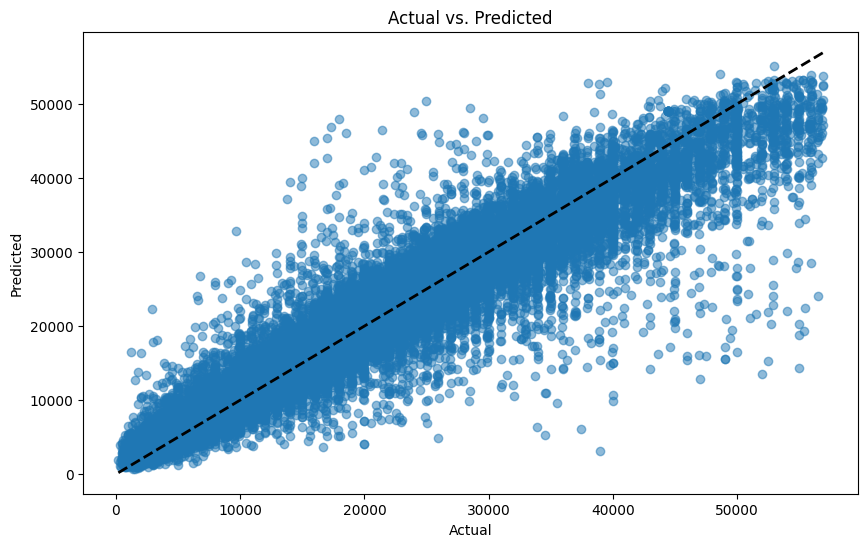

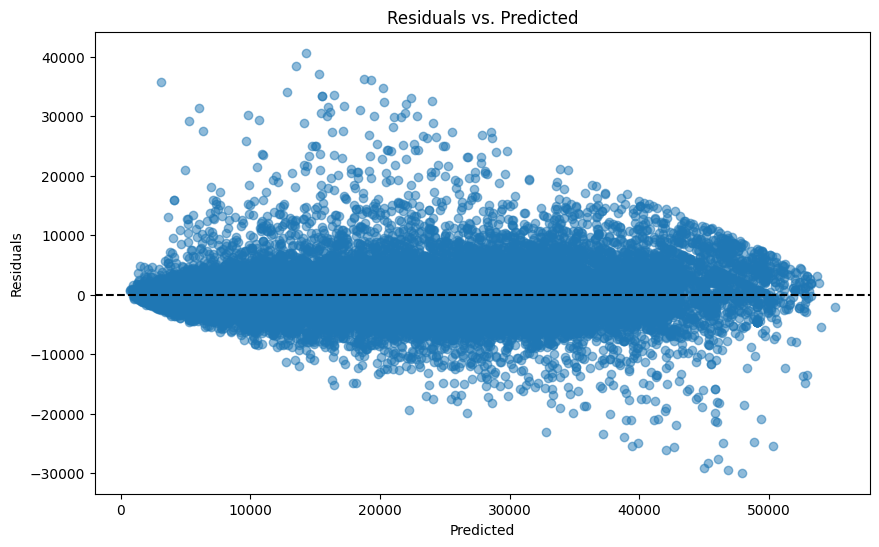

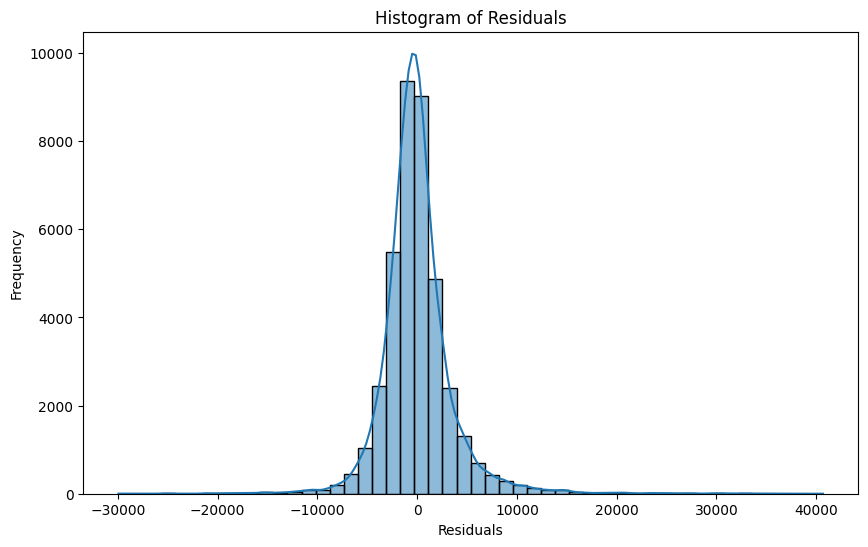

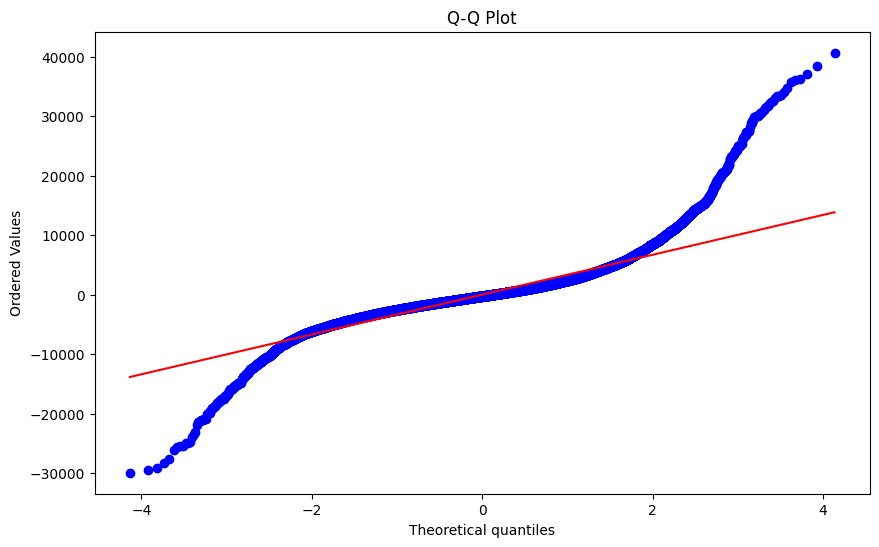

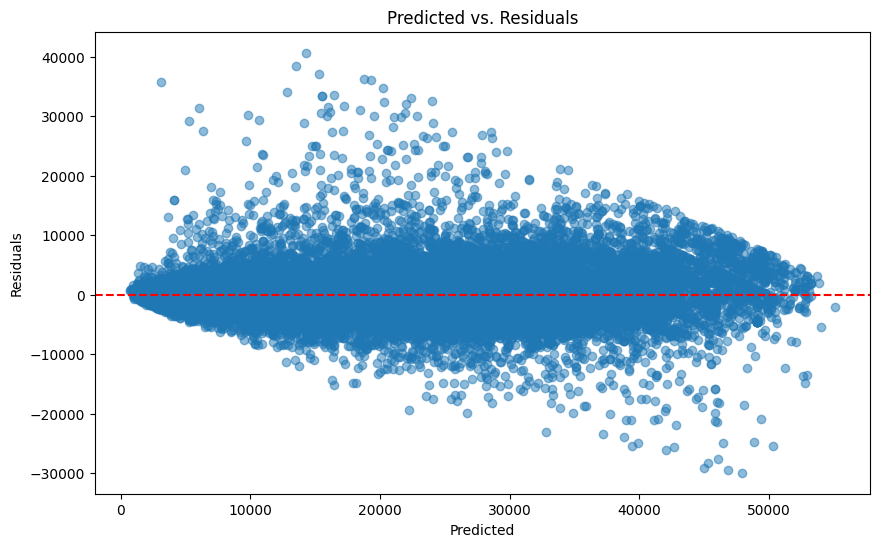

In [174]:


# Calculate residuals
residuals = y_valid - y_pred

# 1. Scatter Plot of Actual vs. Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

# 2. Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.show()

# 3. Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# 4. Q-Q Plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

# 5. Predicted vs. Residuals Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('Predicted vs. Residuals')
plt.show()

In [177]:
# Save the model to a file
with open(r'model/best_xgboost_model.pkl', 'wb') as file:
    pickle.dump(xg_reg, file)
